In [1]:

import numpy
import json
import os
import torch
import io
import pickle
import matplotlib
import random 

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

class PrefNet(nn.Module):

    def __init__(self, nb_obj=2, middle_size=10):
        super().__init__()
        self.f1 = nn.Linear(nb_obj, middle_size)
        self.f2 = nn.Linear(middle_size, middle_size)
        self.out = nn.Linear(middle_size, 1)

    def forward(self, X):
        y = F.relu(self.f1(X))
        y = F.relu(self.f2(y))
        return self.out(y)

    def predict(self, X):
        X_torch = torch.from_numpy(X).float()
#         X_torch = Variable(X_torch, volatile=True)
        return self.forward(X_torch).data.numpy()

    def loading(self, path):
        self.load_state_dict(torch.load(path, map_location=lambda storage, loc: storage))
        return self
    
def savefig(fig, ax, savepath, extension="pdf", save_white=False, **kwargs):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        dirname = os.path.dirname(savepath)
        basename = os.path.basename(savepath)
        
        # Creates empty directory
        os.makedirs(os.path.join(dirname, "white"), exist_ok=True)
        savepath = os.path.join(dirname, "white", basename)

        buf = io.BytesIO()
        pickle.dump(fig, buf)
        buf.seek(0)
        fig = pickle.load(buf)
        
        change_figax_color(fig, ax, **kwargs)
        fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True, dpi=600)
        
        pyplot.close(fig)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            new_colors = [mimic_white_alpha(c) for c in new_colors]
            collection.set_facecolors(new_colors)
            collection.set_alpha(1)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()] 
            new_colors = [mimic_white_alpha(c) for c in new_colors]            
            collection.set_edgecolors(new_colors)
            collection.set_alpha(1)            

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
        
def mimic_white_alpha(color):
    """
    Mimics the color that would be perceived of a color on a white 
    background
    
    :param color: A `matplotlib.collections` of lines
    
    :returns : A `list` of the colors
    """
    c_rgba = matplotlib.colors.to_rgba(color)
    c_rgb, alpha = c_rgba[:3], c_rgba[-1]
    return matplotlib.colors.to_hex(tuple(c * alpha + (1 - alpha) for c in c_rgb))

# Resolution, Bleach, Squirrel

In [67]:
# model = "2021-06-22-10-20-29"
# model = "2021-08-05-07-10-47"
model = "2022-07-07-12-44-45"
model = "2022-12-08-13-37-53"
prefnet = PrefNet(nb_obj=3)
prefnet = prefnet.loading(f"/home-local/optim-sted/prefnet/{model}/weights.t7")
prefnet.eval()
conf = json.load(open(f"/home-local/optim-sted/prefnet/{model}/config.json", "r"))

<IPython.core.display.Javascript object>


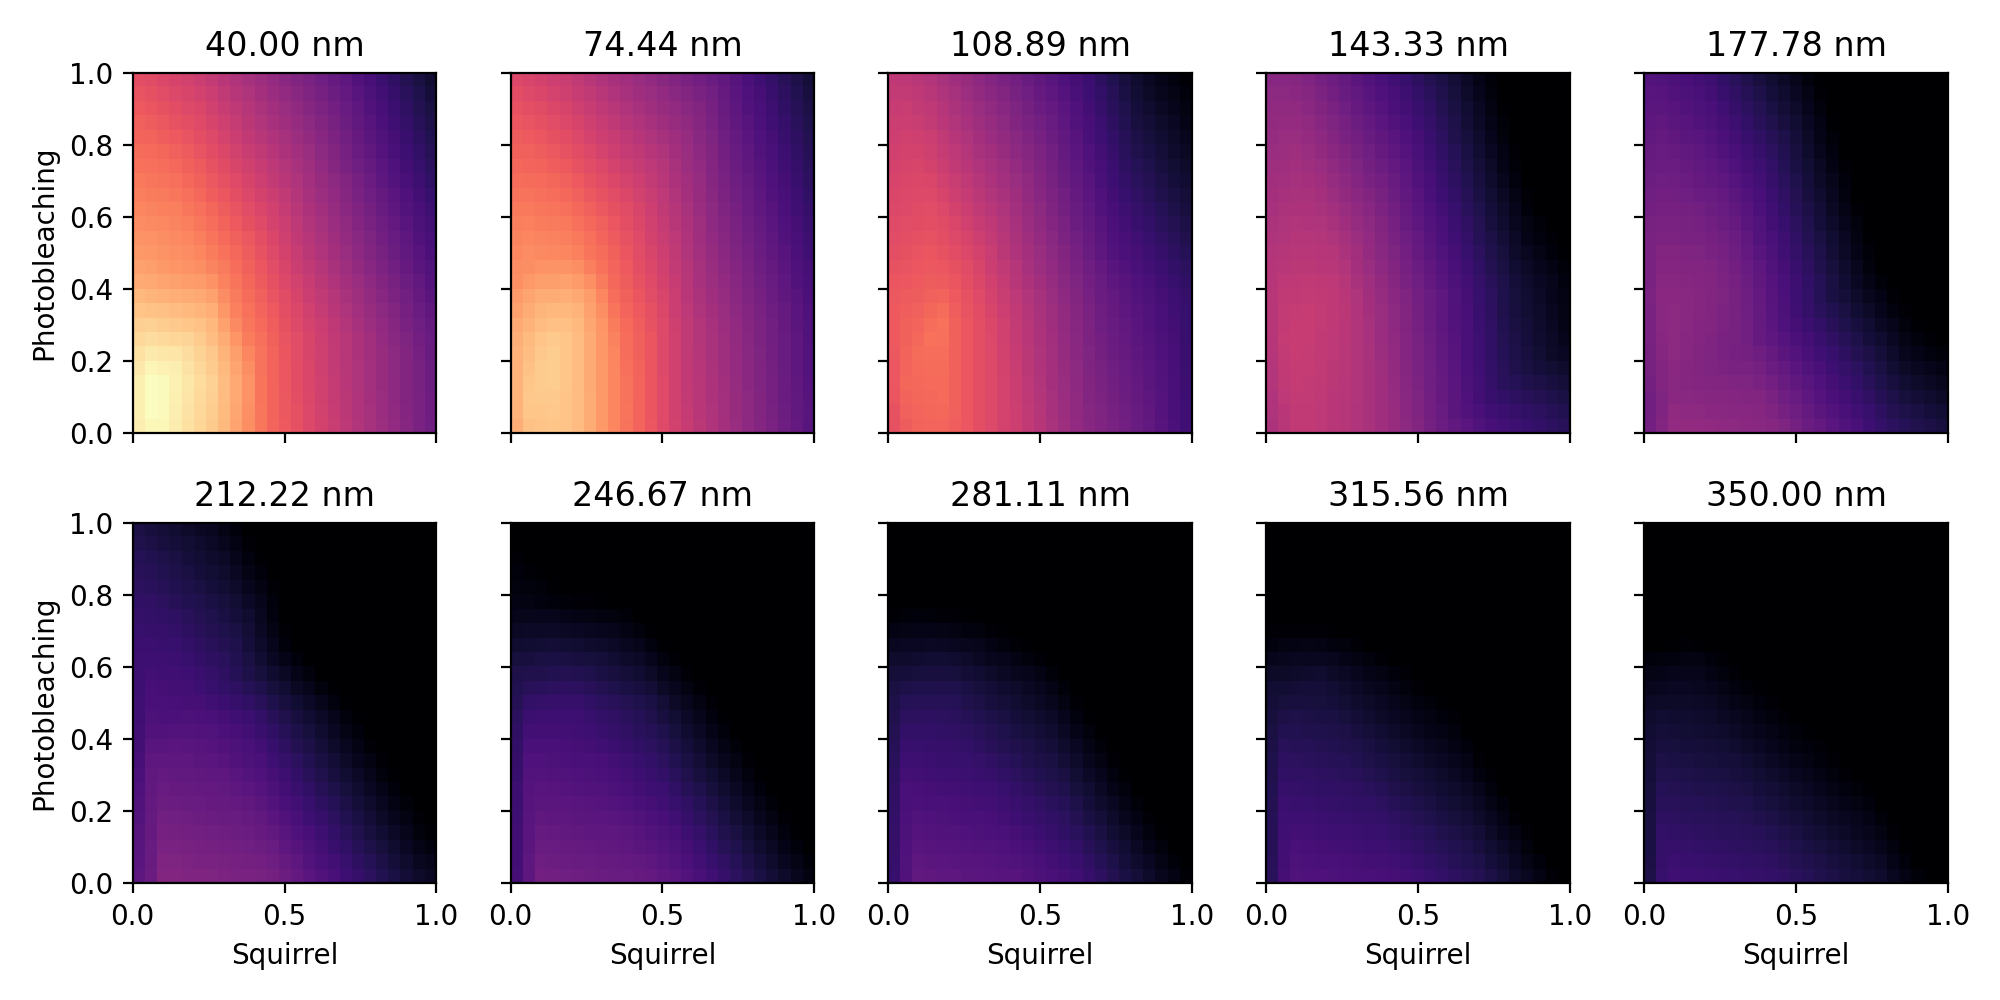

In [68]:
from matplotlib import pyplot

resolution = numpy.linspace(40, 350, 10)
bleach = numpy.linspace(0., 1.0, 25)
squirrel = numpy.linspace(0., 1.0, 25)
points = numpy.meshgrid(
    resolution,
    squirrel,
    bleach,
    indexing="ij"
)
grid = numpy.concatenate([p.ravel()[:, numpy.newaxis] for p in points], axis=-1)
grid = (grid - numpy.array(conf["train_mean"])) / numpy.array(conf["train_std"])
out = prefnet.predict(grid)
out = numpy.transpose(out.reshape(len(resolution), len(bleach), len(squirrel)), axes=(0, 2, 1))

fig,axes = pyplot.subplots(2,5, figsize=(10,5), tight_layout=True, sharex=True, sharey=True)
for _out, ax, r in zip(out, axes.ravel(), resolution):
    ax.imshow(
        _out, vmin=numpy.quantile(out, 0.25), vmax=out.max(), 
        origin="lower", extent=(bleach.min(), bleach.max(), squirrel.min(), squirrel.max()), aspect="auto",
        cmap="magma"
    )
    ax.set(
        title="{:0.2f} nm".format(r)
    )
for ax in axes[1, :]:
    ax.set(xlabel="Squirrel")
for ax in axes[:, 0]:
    ax.set(ylabel="Photobleaching")    
# savefig(fig, axes, "./panels/resolution-squirrel-bleach", save_white=True)
pyplot.show()

/tmp/ipykernel_3287972/3405092245.py:9: UserWarning: Trying to register the cmap 'nice-prism' which already exists.
  matplotlib.cm.register_cmap(cmap=cmap)
/tmp/ipykernel_3287972/3405092245.py:10: UserWarning: Trying to register the cmap 'nice-prism_r' which already exists.
  matplotlib.cm.register_cmap(cmap=cmap.reversed())


<IPython.core.display.Javascript object>


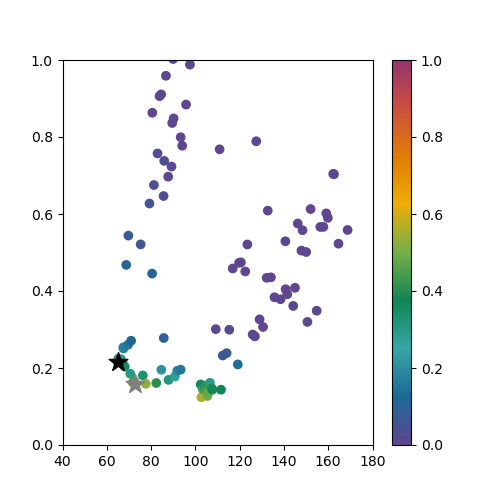

In [46]:
%matplotlib notebook
import h5py, random
import matplotlib

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
)
matplotlib.cm.register_cmap(cmap=cmap)
matplotlib.cm.register_cmap(cmap=cmap.reversed())

def load_pareto_samples(path, trial=0, step=0):
    with h5py.File(os.path.join(path, "optim.hdf5"), "r") as file:
        y_samples = file["y_samples"][f"{trial}"][f"{step}"][()].squeeze().T
        selected_indexes = file["selected_indexes"][f"{trial}"][f"{step}"][()]
    return y_samples, selected_indexes

PATH = "../../data/20221208-user-click"
y_samples, selected_indexes = load_pareto_samples(PATH, trial=0, step=random.randrange(0, 975))
index, selected = selected_indexes

fig, ax = pyplot.subplots(figsize=(5,5))
sc = ax.scatter(y_samples[:, 0], y_samples[:, 1], c=y_samples[:, 2], vmin=0, vmax=1, cmap="nice-prism")
pyplot.colorbar(sc, ax=ax)
ax.scatter(y_samples[selected, 0], y_samples[selected, 1], c="black", marker="*", s=200)

samples = (y_samples - numpy.array(conf["train_mean"])) / numpy.array(conf["train_std"])
out = prefnet.predict(samples).ravel()
selected = out.argmax()
ax.scatter(y_samples[selected, 0], y_samples[selected, 1], c="grey", marker="*", s=200)

ax.set(
    ylim=(0, 1), xlim=(40, 180),
)
pyplot.show()

# Resolution, Bleach, SNR

In [105]:
model = "2021-07-12-06-40-29_ResolutionBleachSNR"
# model = "2023-07-14-06-24-13"
model = "2023-07-14-15-20-56"

prefnet = PrefNet(nb_obj=3)
prefnet = prefnet.loading(f"/home-local/optim-sted/prefnet/{model}/weights.t7")
prefnet.eval()
conf = json.load(open(f"/home-local/optim-sted/prefnet/{model}/config.json", "r"))

<IPython.core.display.Javascript object>


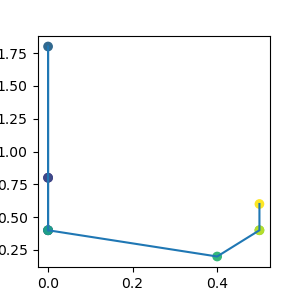

<IPython.core.display.Javascript object>


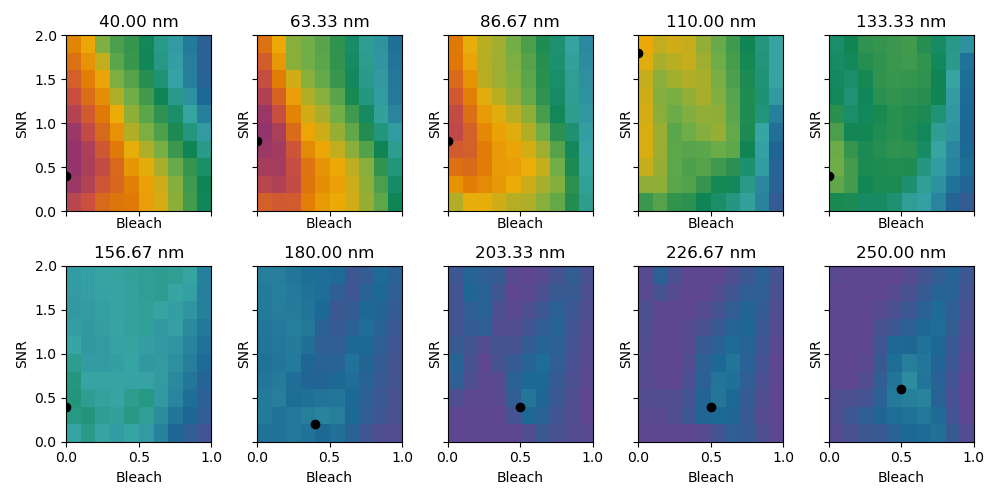

<IPython.core.display.Javascript object>


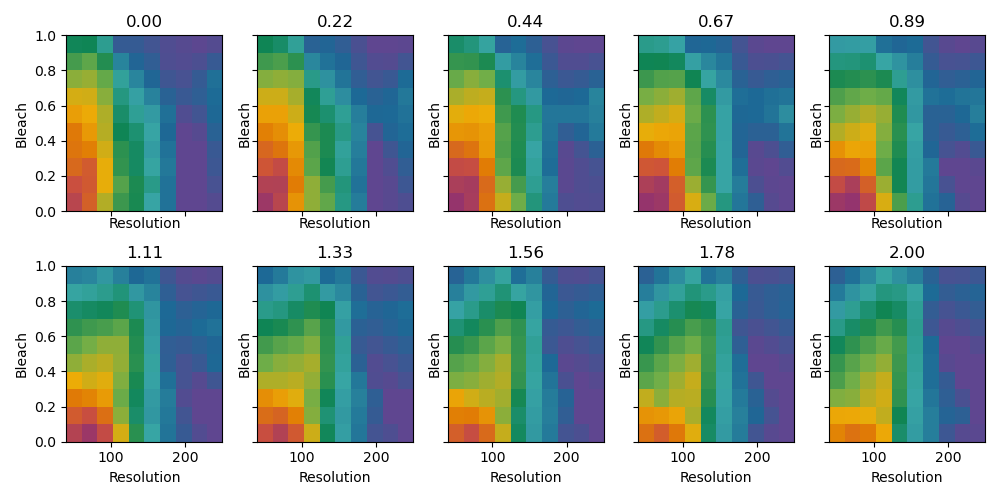

In [106]:
from matplotlib import pyplot

resolution = numpy.linspace(40, 250, 10)
bleach = numpy.linspace(0, 1.0, 10)
snr = numpy.linspace(0, 2.0, 10)
points = numpy.meshgrid(
    resolution,
    bleach,
    snr,
    indexing="ij"
)
grid = numpy.concatenate([p.ravel()[:, numpy.newaxis] for p in points], axis=-1)
grid = (grid - numpy.array(conf["train_mean"])) / numpy.array(conf["train_std"])
out = prefnet.predict(grid)
out = numpy.transpose(out.reshape(len(resolution), len(bleach), len(snr)), axes=(0, 2, 1))
# print(out.shape)

coords = []
for _out in out:
    argmax = numpy.argmax(_out)
    y, x = numpy.unravel_index(argmax, _out.shape)
    x = x / _out.shape[1] * (bleach.max() - bleach.min()) + bleach.min()
    y = y / _out.shape[0] * (snr.max() - snr.min()) + snr.min()  
    
    coords.append((y, x))

coords = numpy.array(coords)
fig, ax = pyplot.subplots(figsize=(3,3))
ax.plot(coords[:, 1], coords[:, 0])
ax.scatter(coords[:, 1], coords[:, 0], c=resolution)
pyplot.show()

fig,axes = pyplot.subplots(2,5, figsize=(10,5), tight_layout=True, sharex=True, sharey=True)
for _out, ax, r in zip(out, axes.ravel(), resolution):
    ax.imshow(
        _out, vmin=numpy.quantile(out, 0.05), vmax=out.max(), 
        origin="lower", extent=(bleach.min(), bleach.max(), snr.min(), snr.max()), aspect="auto",
        cmap="nice-prism"
    )
    argmax = numpy.argmax(_out)
    y, x = numpy.unravel_index(argmax, _out.shape)
    x = x / _out.shape[1] * (bleach.max() - bleach.min()) + bleach.min()
    y = y / _out.shape[0] * (snr.max() - snr.min()) + snr.min()    
    ax.scatter(x, y, color="black")
    ax.set(
        title="{:0.2f} nm".format(r), xlabel="Bleach", ylabel="SNR"
    )
pyplot.show()

out = numpy.transpose(out, axes=(1, 2, 0))
fig,axes = pyplot.subplots(2,5, figsize=(10,5), tight_layout=True, sharex=True, sharey=True)
for _out, ax, r in zip(out, axes.ravel(), snr):
    ax.imshow(
        _out, vmin=numpy.quantile(out, 0.05), vmax=out.max(), 
        origin="lower", extent=(resolution.min(), resolution.max(), bleach.min(), bleach.max()), aspect="auto",
        cmap="nice-prism"
    )
#     argmax = numpy.argmax(_out)
#     y, x = numpy.unravel_index(argmax, _out.shape)
#     x = x / _out.shape[1] * (bleach.max() - bleach.min()) + bleach.min()
#     y = y / _out.shape[0] * (snr.max() - snr.min()) + snr.min()    
#     ax.scatter(x, y, color="black")
    ax.set(
        title="{:0.2f}".format(r), xlabel="Resolution", ylabel="Bleach"
    )
pyplot.show()

# Examples

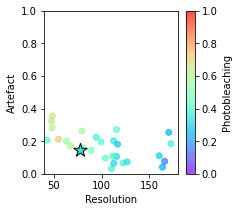

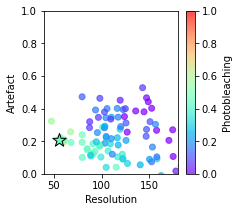

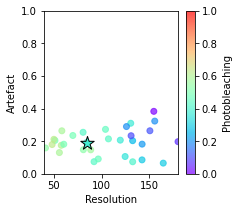

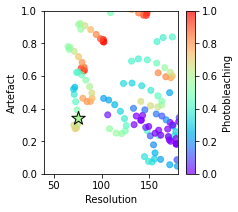

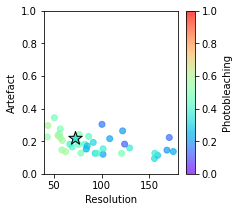

In [48]:
for i in range(5):
    random.seed(42 + i)
    PATH = "../../data"
    X, y = pickle.load(open(os.path.join(PATH, "3objs-ResolutionSquirrelBleach-pref.pkl"), "rb"))
    idx = random.choice(range(len(X)))

    fig, ax = pyplot.subplots(figsize=(3,3))
    sc = ax.scatter(X[idx][:, 0], X[idx][:, 1], c=X[idx][:, 2], cmap="rainbow", vmin=0, vmax=1, alpha=0.7)
    ax.set(
        xlim=(40, 180), ylim=(0, 1), ylabel="Artefact", xlabel="Resolution"
    )
    ax.scatter(X[idx][y[idx], 0], X[idx][y[idx], 1], c=X[idx][y[idx], 2], cmap="rainbow", vmin=0, vmax=1, marker="*", s=200, edgecolor="k")
    cbar = pyplot.colorbar(sc, ax=ax)
    cbar.set_label("Photobleaching")
    savefig(fig, ax, f"./panels/selection-example-{i}", save_white=True)
    pyplot.show()